In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import fastai
import fastai.dataset
import pydicom
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from fastai.conv_learner import *
from fastai.dataset import *


In [139]:
torch.backends.cudnn.benchmark=True

In [ ]:
PATH = Path('path/to/data')

In [140]:
def isdicom(fn):
    if fn.endswith('.dcm'):
        return True
    with open(fn) as fh:
        fh.seek(0x80)
        return fh.read(4)=='DICM'


def open_image(fn):
    """ Modifying fastai's open_image to allow dicom files to be read.
    from https://www.kaggle.com/dovgro/fastai-exploration

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    elif isdicom(fn):
        slice = pydicom.read_file(fn)
        if slice.PhotometricInterpretation.startswith('MONOCHROME'):
            # Make a fake RGB image
            im = np.stack([slice.pixel_array]*3,-1)
            return im / ((1 << slice.BitsStored)-1)
        else:
            raise OSError('Unsupported DICOM image with PhotometricInterpretation=={}'.format(slice.PhotometricInterpretation))
    else:
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

fastai.dataset.isdicom=isdicom
fastai.dataset.pydicom=pydicom
fastai.dataset.open_image=open_image

In [142]:
def hw_bb(row): return np.array([row['y'], row['x'], row['height']+row['y'], row['width']+row['x']])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def parse_data(df):
    
    parsed = collections.defaultdict(lambda:{'dicom': None,    
        'label': None,
        'boxes': []})
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        parsed[pid]['dicom'] = str(f'{pid}.dcm')
        parsed[pid]['label'] = row['Target']
        parsed[pid]['boxes'].append(hw_bb(row))

    return parsed


def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[-2:]-x[:2]), reverse=True)
    return [b[0]]


def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax


def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
    
def draw_rect(ax, b, col = 'white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor = col, lw=2))
    draw_outline(patch,4)
    
    
def draw_text(ax, xy, txt, sz=14, col='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=col, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
    
def draw_im(im, ann, ax=None):
    ax = show_img(im, figsize=(16,8), ax =ax)
    l = ann['label']
    for b in ann['boxes']:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], l, sz=16)  
        
        
def draw_idx(i, ax=None):
    im_a = parsed_lrg_p[i]
    im = open_image('path/to/training/images/'+parsed[i]['dicom'])
    draw_im(im, im_a, ax=ax)

In [143]:
label_csv = PATH/'stage_2_train_labels.csv'
df = pd.read_csv(label_csv)
label_df = df.filter(['patientId', 'Target'], )
label_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [144]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [145]:
df.x.fillna(0, inplace=True)
df.y.fillna(0, inplace=True)
df.width.fillna(0, inplace=True)
df.height.fillna(0, inplace=True)
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [146]:
parsed = parse_data(df)
len(parsed)

26684

In [147]:
cats = {'0': 'normal', '1': 'pneumonia'}

In [148]:
parsed_lrg = {a: {'dicom': b['dicom'],
                  'label': b['label'],
                  'boxes': get_lrg(b['boxes'])} for a, b in parsed.items()}

In [150]:
parsed_lrg["00436515-870c-4b36-a041-de91049b9ab4"]

{'dicom': '00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'boxes': [array([152., 562., 605., 818.])]}

In [152]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'
BB_CSV = PATH/'tmp/bb.csv'

In [153]:
df = pd.DataFrame({'fn': [parsed_lrg[o]['dicom'] for o in parsed_lrg],
                   'cat': [parsed_lrg[o]['label'] for o in parsed_lrg],
                   'bbox': [' '.join(str(int(p)) for p in parsed_lrg[o]['boxes'][0]) for o in parsed_lrg]})

In [154]:
df.head()

,fn,cat,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,0,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,0,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,0,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,1,152 562 605 818


In [155]:
df[['fn', 'cat']].to_csv(CSV, index=False)
df[['fn', 'bbox']].to_csv(BB_CSV, index=False)

## Classification and BBoxes

In [157]:
f_model = resnet34
sz=224
bs=64

In [158]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)

In [159]:
val_idxs = get_cv_idxs(len(df))

In [160]:
md = ImageClassifierData.from_csv(PATH, 'stage_2_train_images', BB_CSV, tfms=tfms, bs=bs, continuous=True, val_idxs=val_idxs)

In [161]:
md2 = ImageClassifierData.from_csv(PATH, 'stage_2_train_images', CSV, tfms=tfms_from_model(f_model, sz), bs=bs)

In [162]:
class ObjDetDataset(Dataset):
    def __init__(self, ds, y2): 
        self.ds = ds 
        self.y2 = y2
    
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [163]:
trn_ds = ObjDetDataset(md.trn_ds, md2.trn_y)
val_ds = ObjDetDataset(md.val_ds, md2.val_y)

In [173]:
trn_ds[4][1]

(array([ 32., 121., 129., 175.], dtype=float32), 1)

In [165]:
md.trn_dl.dataset = trn_ds
md.val_dl.dataset = val_ds

In [166]:
x,y=next(iter(md.val_dl))
idx=0
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([0., 0., 0., 0.], dtype=float32)

In [174]:
len(md.trn_ds)


21348

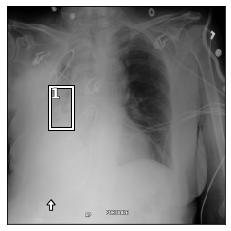

In [34]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [175]:
custom_head_clasreg = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=custom_head_clasreg)



In [176]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [36]:
x, y = next(iter(md.trn_dl))

In [37]:
x.shape

torch.Size([64, 3, 224, 224])

In [ ]:
ratios = []

for i in range(200):
    x, y = next(iter(md_box.trn_dl))
    t = learn.model(V(x))
    
    bb_t,c_t = y
    bb_i,c_i = t[:, :4], t[:, 4:]
    bb_i = F.sigmoid(bb_i)*sz
    
    reg = F.l1_loss(bb_i, V(bb_t)).data.cpu().numpy()
    clas = F.cross_entropy(c_i, V(c_t)).data.cpu().numpy()
    ratios.append((reg/clas)[0])

In [193]:
scalar = int(np.mean(ratios))


In [178]:
def binary_loss(y,p):
    return np.mean(-(y*np.log(p)+(1-y)*np.log(1-p)))


def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224

    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t, ignore_index = -1)*scalar


def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data


def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 79%|███████▊  | 263/334 [10:23<02:44,  2.32s/it, loss=592]

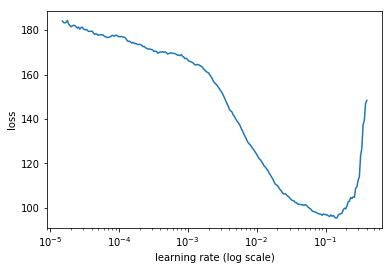

In [121]:
learn.lr_find()
learn.sched.plot()

In [122]:
lr = 2e-2

In [123]:
learn.fit(lr, 1, cycle_len=3,use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      76.400633  74.645138  0.802474   25.202412 
    1      73.612387  72.431222  0.814468   24.273894 
    2      71.363734  71.781689  0.814468   24.109807 


[array([71.78169]), 0.8144677662063038, 24.109806515466328]

In [124]:
learn.save('bbclassdef')

In [125]:
learn.freeze_to(-2)

In [126]:
lrs = np.array([lr/100,lr/10,lr])

 75%|███████▌  | 252/334 [10:33<03:34,  2.61s/it, loss=313]

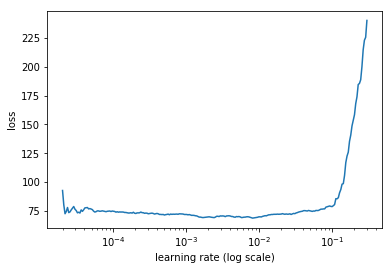

In [127]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [128]:
lr = 1e-5

In [129]:
learn.fit(lrs/10, 1, cycle_len=3,use_clr=(32,10))



epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      65.522504  66.166635  0.836394   22.672077 
    1      62.259124  65.842408  0.83527    22.166461 
    2      54.659651  66.040439  0.836582   21.647584 


[array([66.04044]), 0.836581709056065, 21.647583881418207]

In [130]:
 learn.save('bbclassdef1')

In [158]:
learn.load('bbclassdef1')

In [133]:
learn.unfreeze()


In [134]:
learn.fit(lrs/10, 1, cycle_len=3,use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      61.159502  69.068207  0.826462   22.984288 
    1      55.736856  66.159629  0.839393   21.449412 
    2      45.0101    70.493674  0.835645   21.431831 


[array([70.49367]), 0.8356446775718072, 21.43183136415267]

In [135]:
 learn.save('bbclassdef2')

In [179]:
learn.load('bbclassdef2')

In [180]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [184]:
from scipy.special import expit
i=0

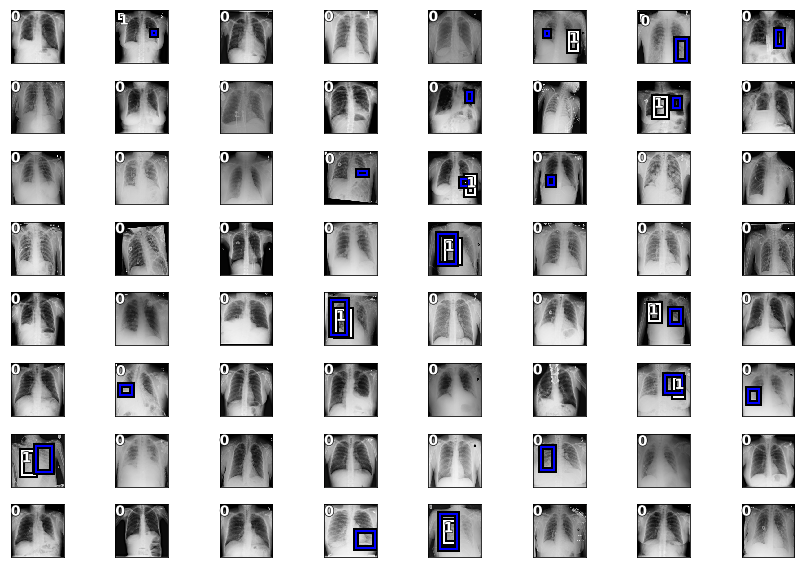

In [185]:
fig, axes = plt.subplots(8, 8, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    tb = bb_hw(to_np(_[0][i])); b
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_rect(ax, tb, col ='blue')
    draw_text(ax, b[:2], md2.classes[c])
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

In [164]:
learn.unfreeze()

Did some more training just in case. But val_loss increased after this

In [165]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      50.541049  73.378725  0.81578    23.367799 
    1      50.02635   73.96895   0.833771   22.025275 
    2      47.780924  74.554787  0.837706   21.42017  
    3      38.985795  80.579645  0.830772   22.136065 
    4      32.697614  84.2029    0.811094   23.639495 
    5      26.411842  91.474886  0.828523   22.192615 
    6      21.257356  94.767213  0.821214   23.459626 
    7      14.046738  104.523792 0.827399   22.106103 
    8      14.112857  106.99334  0.832834   22.339573 
    9      10.34669   109.668494 0.83096    21.902419 


[array([109.66849]), 0.8309595201505178, 21.902418605569956]

In [198]:
y = learn.predict()
x,_ = next(iter(md.val_ds))

In [203]:
len(y)

5336

In [52]:
from scipy.special import expit

In [138]:
pred = learn.predict_array(im[None]);
preds = np.argmax(pred,-1)

In [256]:
def iou(box1, box2):
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    assert w1 * h1 >= 0
    assert w2 * h2 >= 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union
    

In [ ]:
iou

In [187]:
len(md.val_ds)

5336

In [210]:
positive_boxes = []

In [211]:
for i in range(len(md.val_ds)):
    if md.val_ds[i][1][1] == 1:
        positive_boxes.append(md.val_ds[i][1][0])

In [212]:
positive_boxes

[array([ 91., 154., 106., 171.], dtype=float32),
 array([ 91.,  50., 111.,  69.], dtype=float32),
 array([122., 166., 217., 213.], dtype=float32),
 array([ 84., 146., 154., 175.], dtype=float32),
 array([ 46., 163.,  86., 184.], dtype=float32),
 array([ 74., 152., 114., 180.], dtype=float32),
 array([ 83., 142., 102., 183.], dtype=float32),
 array([118., 140., 147., 174.], dtype=float32),
 array([108.,  65., 141.,  90.], dtype=float32),
 array([ 51.,  40., 179., 116.], dtype=float32),
 array([ 33.,  30., 178.,  96.], dtype=float32),
 array([ 69., 139., 135., 185.], dtype=float32),
 array([ 91.,  20., 133.,  70.], dtype=float32),
 array([ 50., 119., 126., 190.], dtype=float32),
 array([111.,  26., 168.,  72.], dtype=float32),
 array([ 53., 107., 163., 174.], dtype=float32),
 array([ 55.,  35., 155.,  91.], dtype=float32),
 array([113., 134., 183., 218.], dtype=float32),
 array([ 42.,  49., 187., 119.], dtype=float32),
 array([ 99.,  70., 127., 107.], dtype=float32),
 array([ 41.,  58., 

In [248]:
positive_preds = []

In [250]:
for p in y:
    if (np.argmax(p[4:]))==1:
        positive_preds.append(expit(p[:4])*224)

In [267]:
for i in range(len(positive_preds)):
    accuracy = accuracy + iou(positive_boxes[i], positive_preds[i])
mean_accuracy = accuracy/(len(positive_preds))

In [268]:
mean_accuracy

0.38618540821965086